# Building a basic LLM Agent using Langgraph

In [48]:
# From https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/

In [49]:
import openai
import re
import os
from dotenv import load_dotenv
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from typing import Literal
from langchain_core.tools import tool

_ = load_dotenv()

## 1. Setup the LLM

In [50]:
#
# Params
#
OPENAI_MODEL_NAME = "gpt-4o-mini"
OPENAI_MODEL_TEMPERATURE = 0

#
# Initialize OpenAI
#
llm = ChatOpenAI(model=OPENAI_MODEL_NAME, temperature=OPENAI_MODEL_TEMPERATURE)

client = OpenAI()

def call_completion(system_prompt, user_prompt, model, temperature=1, client=client):
    response = client.chat.completions.create(
    model=model,
    temperature=temperature,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
    )
    
    return response.choices[0].message.content

## 2. Creating the Agent

### 2.1 Define the tools

In [51]:
#
# Define the tools that will be available to the agent. The description of each tool will be used by the agent to understand what the tool does.
#

import plantuml
import os

#
# Implementing the tools available to the agent
#

@tool
def generate_uml_code(user_story):
    """This tool generates a PlantUML diagram code from a user story (str)."""

    uml_code = call_completion(system_prompt="Generate the PlantUML code for the input user story:", user_prompt=str(user_story), model=OPENAI_MODEL_NAME, temperature=OPENAI_MODEL_TEMPERATURE)

    return uml_code

@tool
def render_uml_diagram(uml_code, diagram_name):
    """This tool renders a PlantUML diagram from a PlantUML UML code. The diagram is saved as a PNG file with the provided name, returning the path to the saved file if successful."""
    plantuml_code = plantuml.PlantUML(url='http://www.plantuml.com/plantuml/img/')
    diagram = plantuml_code.processes(uml_code)

    diagram_name = diagram_name.replace(" ", "_") + ".png"
    with open(diagram_name, "wb") as image_file:
        image_file.write(diagram)

    return "Diagram saved at: " +  os.path.abspath(diagram_name)

tools = [generate_uml_code, render_uml_diagram]

### 2.2 Create the graph

In [52]:
from langchain_core.messages.system import SystemMessage

#
# The built-in create_react_agent function embeds all the logic needed to create a basic ReAct agent
#
graph = create_react_agent(model=llm, tools=tools)

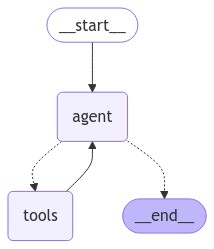

In [53]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
#
# Define an utility function to print the stream of messages
#
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

## 3. Execute the Agent

In [55]:
description = """
Below is a description of the functional requirements for a simple bank account management application in Python:

### Functional Requirements

1. **Create Bank Account**  
   - **Description**: The system should allow users to create new bank accounts.
   - **Inputs**: 
     - Account holder's name
     - Initial deposit amount
   - **Outputs**: 
     - Confirmation of account creation
     - Account details (Account Number, Creation Date, Initial Balance)
   - **Processing**:
     - Validate input data (e.g., ensure initial deposit is a positive number).
     - Generate a unique account number.
     - Set the creation date as the current date.
     - Store account information in the system.
   - **Rules**:
     - Each account must have a unique account number.
     - Initial deposit should meet the minimum balance requirement if defined.

2. **Transfer Money Between Accounts**  
   - **Description**: The system should facilitate money transfers between two accounts.
   - **Inputs**: 
     - Source account number
     - Destination account number
     - Transfer amount
   - **Outputs**: 
     - Confirmation of successful transfer
     - Updated balances for both accounts
     - Error messages for failed transactions
   - **Processing**:
     - Validate input data (e.g., ensure accounts exist, the transfer amount is positive, and the source account has sufficient funds).
     - Deduct the transfer amount from the source account.
     - Credit the transfer amount to the destination account.
     - Log the transaction details for record-keeping.
   - **Rules**:
     - Transfers cannot exceed the available balance of the source account.
     - Both source and destination account numbers must be valid and exist in the system.
"""

In [56]:
question = "Generate some use case diagrams from the following functional requirements:\n" + description + "\nEnsure that the diagrams are correclty rendered and saved as images."

inputs = {"messages": [("user", question)]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Generate some use case diagrams from the following functional requirements:

Below is a description of the functional requirements for a simple bank account management application in Python:

### Functional Requirements

1. **Create Bank Account**  
   - **Description**: The system should allow users to create new bank accounts.
   - **Inputs**: 
     - Account holder's name
     - Initial deposit amount
   - **Outputs**: 
     - Confirmation of account creation
     - Account details (Account Number, Creation Date, Initial Balance)
   - **Processing**:
     - Validate input data (e.g., ensure initial deposit is a positive number).
     - Generate a unique account number.
     - Set the creation date as the current date.
     - Store account information in the system.
   - **Rules**:
     - Each account must have a unique account number.
     - Initial deposit should meet the minimum balance requirement i

In [57]:
import plantuml
from IPython.display import Image, display


def render_uml_diagram(uml_code):
    plantuml_code = plantuml.PlantUML(url='http://www.plantuml.com/plantuml/img/')
    diagram = plantuml_code.processes(uml_code)

    with open('diagram.png', 'wb') as image_file:
        image_file.write(diagram)

    return diagram


d = """
@startuml
Bob -> Alice : hello
@enduml
"""

res = render_uml_diagram(d)

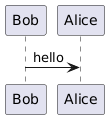

In [58]:
import io

display(Image(data=io.BytesIO(res).getvalue()))

In [59]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph LR;
    A--> B & C & D;
    B--> A & E;
    C--> A & E;
    D--> A & E;
    E--> B & C & D;
""")